# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to what subreddit it belongs to?_

Your method for acquiring the data will be scraping threads from at least two subreddits. 

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts which subreddit a given post belongs to.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [1]:
import requests
import time
import json
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords

In [2]:
def get_reddit_posts(sub_list, website = 'reddit.com'): # pass in list of subreddits
    headers = {'User-agent': 'Chuck Bob MAC 5.5'}
    posts = [] # list of dicts for each feature in a reddit post
    for subreddit in sub_list:
        url = 'http://www.{}/r/{}.json'.format(website, subreddit)
        after = None # each subreddit must start w 'after = None' to start retrieving most recent results
        # start range at 1 to make status message work properly (can't multiply by 0)
        for i in range(1, 41): # to get maximum of 1000 posts
            if after == None:
                params = {}
            else:
                params = {'after': after} # prevents duplication of get requests
            res = requests.get(url, params = params, headers = headers)
            if res.status_code == 200:
                json = res.json()
                # create a list of dicts for each post
                posts.extend([post['data'] for post in json['data']['children']]) # json['data']['children'] is a list of dictionaries with api info on each post
                after = json['data']['after']
            else:
                print('Oops... something went wrong! Status Code: {}'.format(res.status_code))
                break
            if i != 40:
                print('For subreddit, {}, about {} percent of posts have been retrieved'.format(subreddit, round((i * 25 / 1000) * 100)[1]), end = '\r')
            else:
                print('Subreddit {} has been retrieved'.format(subreddit))
            
            # SAVE DATA TO CSV AFTER EACH API CALL
            pd.DataFrame(posts).to_csv('posts.csv', index = False)
            time.sleep(3)
    return posts

In [3]:
# Only run this cell if you want to make an API call
# subreddits = ['financialindependence', 'personalfinance']
# posts = get_reddit_posts(subreddits)

In [4]:
# if subreddit posts are already downloaded, run this cell to load from csv
posts = pd.read_csv('./posts.csv')

In [5]:
post_df = pd.DataFrame(posts)

In [6]:
post_df.head()

,approved_at_utc,approved_by,archived,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,...,thumbnail_height,thumbnail_width,title,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,NaN,NaN,False,ER10years_throwaway,NaN,NaN,NaN,[],NaN,FI/ER'd in 2005 at 36,...,NaN,NaN,Initial financial independence survey results ...,431,https://www.reddit.com/r/financialindependence...,[],NaN,False,all_ads,6
1,NaN,NaN,False,Flipnkraut,NaN,NaN,NaN,[],NaN,NaN,...,NaN,NaN,Stop trying to keep up with the FIRE Joneses,530,https://www.reddit.com/r/financialindependence...,[],NaN,False,all_ads,6
2,NaN,NaN,False,outgetting,NaN,NaN,NaN,[],NaN,NaN,...,NaN,NaN,Hit 4M USD NW,238,https://www.reddit.com/r/financialindependence...,[],NaN,False,all_ads,6
3,NaN,NaN,False,redfaro,NaN,NaN,NaN,[],NaN,NaN,...,NaN,NaN,"I'm sorry, that's just not my kind of retireme...",132,https://www.reddit.com/r/financialindependence...,[],NaN,False,all_ads,6
4,NaN,NaN,False,YeezyFishstix,NaN,NaN,NaN,[],NaN,NaN,...,NaN,NaN,"I don't work in the tech field, and I don't ea...",55,https://www.reddit.com/r/financialindependence...,[],NaN,False,all_ads,6


> We aren't really concerned with the majority of missing values, because the only columns we care about are `subreddit`, `title`, and `selftext`.

In [7]:
len(post_df['subreddit'])

1975

**Cleaning**  
- Grab the parts of each post that are relevant; `selftext` (the post description), `title`, and `subreddit` (the target variable)
- Fill any missing/null values with an empty string (because they were most likely just not input by the Reddit user in the first place)
- Combine the title and description for each post to create one individual document per post

**Pre-Processing**  

After creating the documents, I will need to preprocess them before I can use `CountVectorizer` to count each word. That will consist of the following steps:

- `Regex` to remove punctuation and any other unwanted elements
- Remove stop words
- Lemmatize/Stem words

In [8]:
corpus = post_df[['subreddit', 'title', 'selftext']]

In [9]:
corpus.head()

,subreddit,title,selftext
0,financialindependence,Initial financial independence survey results ...,The initial survey results - only including re...
1,financialindependence,Stop trying to keep up with the FIRE Joneses,I see a lot of people getting down on where th...
2,financialindependence,Hit 4M USD NW,\n\nThrowaway account. We hit 4M NW today! ...
3,financialindependence,"I'm sorry, that's just not my kind of retireme...","Bored at work, and poking around online about ..."
4,financialindependence,"I don't work in the tech field, and I don't ea...","Im 24 and earn about 35k, and feel so discoura..."


In [10]:
corpus.isnull().sum()

subreddit     0
title         0
selftext     25
dtype: int64

> Need to input an empty string for descriptions that are empty

In [11]:
corpus['selftext'].fillna('', inplace = True)

/Users/charleydixon/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [12]:
corpus['selftext'].isnull().sum()

0

In [13]:
# combining title and description into one "document"
corpus['documents'] = corpus['title'] + ' ' + corpus['selftext']

/Users/charleydixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
corpus.head()

,subreddit,title,selftext,documents
0,financialindependence,Initial financial independence survey results ...,The initial survey results - only including re...,Initial financial independence survey results ...
1,financialindependence,Stop trying to keep up with the FIRE Joneses,I see a lot of people getting down on where th...,Stop trying to keep up with the FIRE Joneses I...
2,financialindependence,Hit 4M USD NW,\n\nThrowaway account. We hit 4M NW today! ...,Hit 4M USD NW \n\nThrowaway account. We hit ...
3,financialindependence,"I'm sorry, that's just not my kind of retireme...","Bored at work, and poking around online about ...","I'm sorry, that's just not my kind of retireme..."
4,financialindependence,"I don't work in the tech field, and I don't ea...","Im 24 and earn about 35k, and feel so discoura...","I don't work in the tech field, and I don't ea..."


#### Thought experiment: What is the baseline accuracy for this model?

In [15]:
print(corpus['subreddit'].value_counts(), '\n')
print(corpus['subreddit'].value_counts(normalize = True))

financialindependence    988
personalfinance          987
Name: subreddit, dtype: int64 

financialindependence    0.500253
personalfinance          0.499747
Name: subreddit, dtype: float64


> Baseline accuracy is 50%. The `financialindependence` subreddit has one more post than `personalfinance`, but we have almost perfect balance between classes.

> Great, now that the documents have been created from the title and descriptions for each post it is time to preprocess them for the `CountVectorizer`.

In [16]:
def preprocess(document):
    # remove HTML
    doc_text = BeautifulSoup(document, 'lxml').get_text()
    # remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", doc_text)
    # convert to lower case, split into individual words
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    # remove stop words & lemmatize
    lemmatizer = WordNetLemmatizer()
    meaningful_words = [lemmatizer.lemmatize(w) for w in words if not w in stops]
    # join the words back into one string separated by space, and return the result
    return(' '.join(meaningful_words))

In [17]:
corpus['documents'] = [preprocess(post) for post in corpus['documents']]

/Users/charleydixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
corpus.head()

,subreddit,title,selftext,documents
0,financialindependence,Initial financial independence survey results ...,The initial survey results - only including re...,initial financial independence survey result v...
1,financialindependence,Stop trying to keep up with the FIRE Joneses,I see a lot of people getting down on where th...,stop trying keep fire jones see lot people get...
2,financialindependence,Hit 4M USD NW,\n\nThrowaway account. We hit 4M NW today! ...,hit usd nw throwaway account hit nw today year...
3,financialindependence,"I'm sorry, that's just not my kind of retireme...","Bored at work, and poking around online about ...",sorry kind retirement calculator bored work po...
4,financialindependence,"I don't work in the tech field, and I don't ea...","Im 24 and earn about 35k, and feel so discoura...",work tech field earn figure year feel place su...


### TTS

In [19]:
X = corpus['documents']
y = corpus['subreddit'].map({'financialindependence': 0, 'personalfinance': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## NLP EDA

In [20]:
corpus['char_count'] = corpus['documents'].map(len)
corpus['word_count'] = corpus['documents'].map(lambda x: len(x.split()))

/Users/charleydixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/charleydixon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


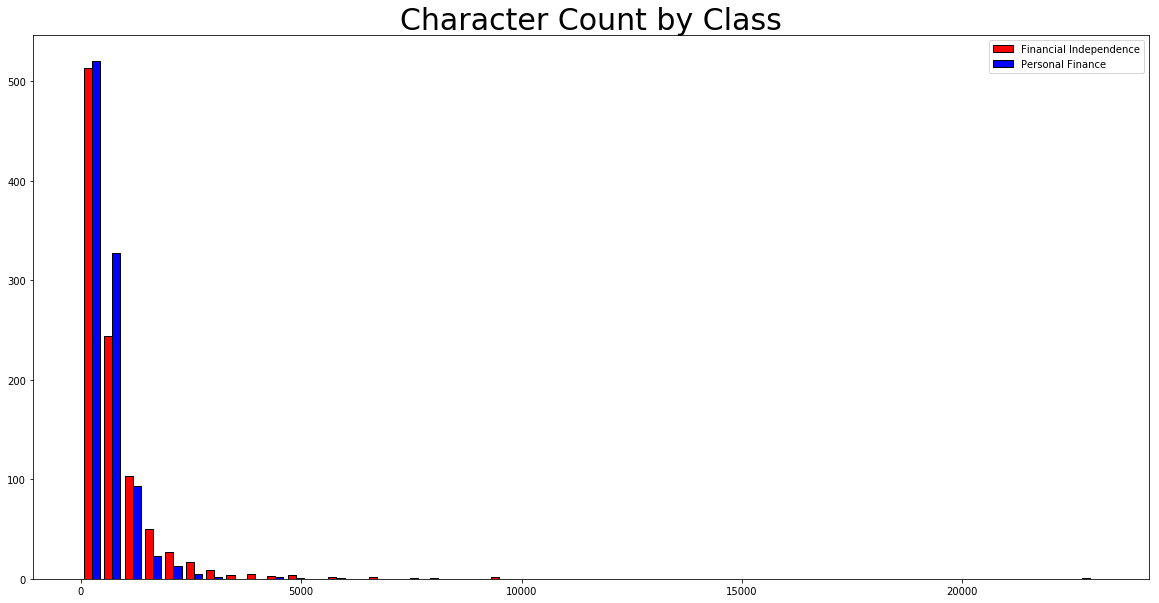

In [21]:
plt.figure(figsize=(20,10))
plt.hist([corpus[corpus['subreddit']=='financialindependence']['char_count'], corpus[corpus['subreddit']=='personalfinance']['char_count']],
         bins=50, color=['red', 'blue'], ec='k')
plt.title('Character Count by Class', fontsize=30)
plt.legend(['Financial Independence', 'Personal Finance'])

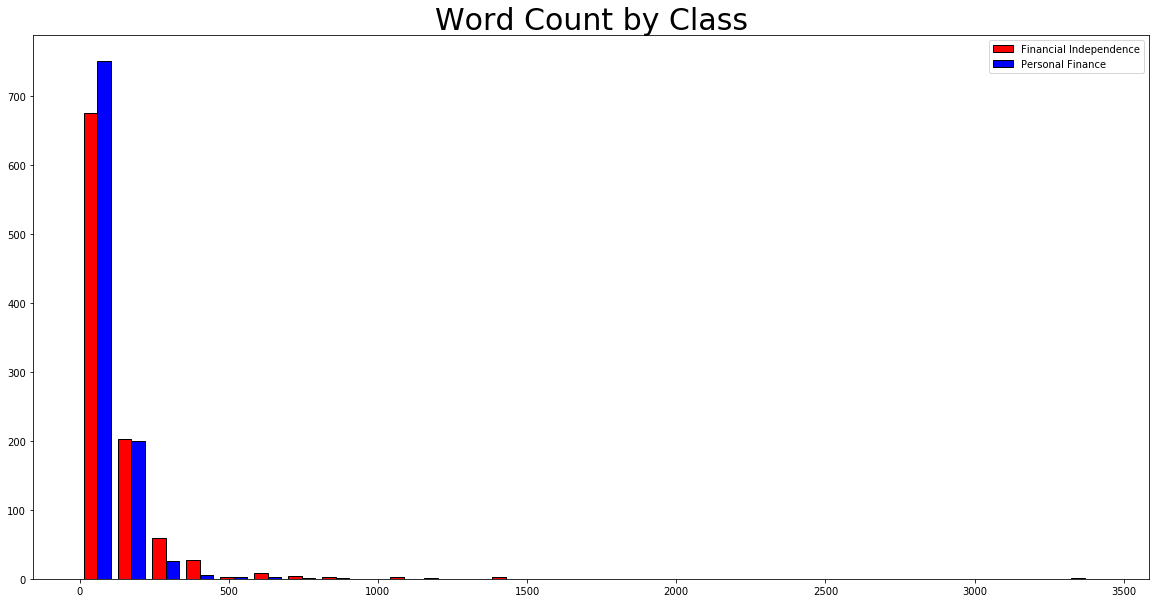

In [22]:
plt.figure(figsize=(20,10))
plt.hist([corpus[corpus['subreddit']=='financialindependence']['word_count'],
          corpus[corpus['subreddit']=='personalfinance']['word_count']],
         bins=30, color=['red', 'blue'], ec='k')
plt.title('Word Count by Class', fontsize=30)
plt.legend(['Financial Independence', 'Personal Finance'])

> Because there are a few posts in each subreddit that are outrageously long, I'm going to remove them to better visualize the word/character counts

In [23]:
fewer_words = corpus[corpus['word_count'] < 1000]

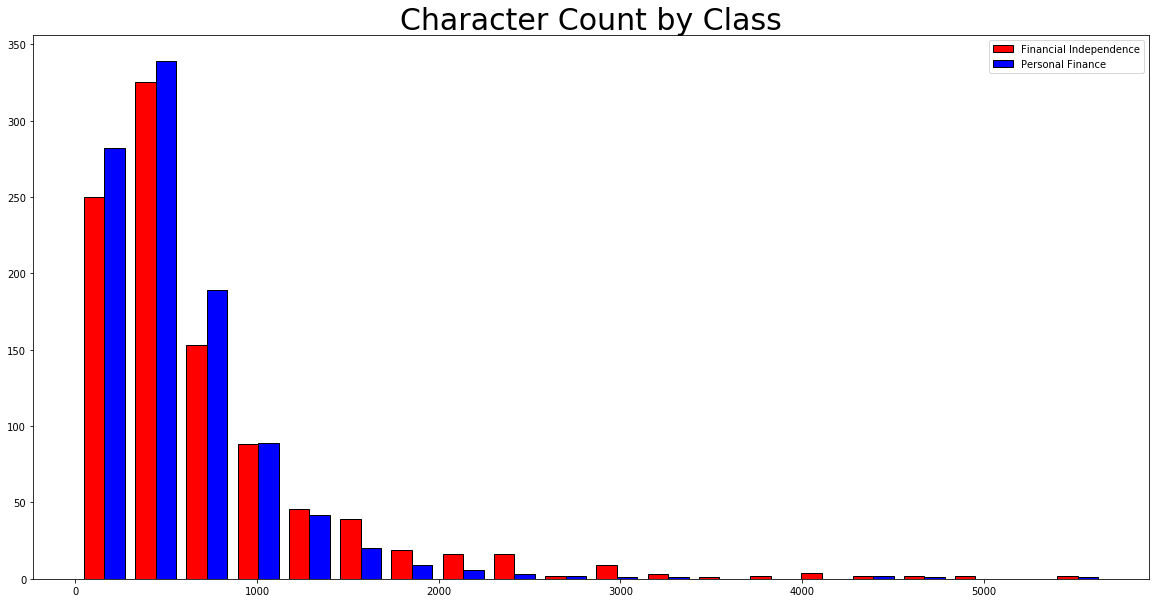

In [24]:
plt.figure(figsize=(20,10))
plt.hist([fewer_words[fewer_words['subreddit']=='financialindependence']['char_count'],
          fewer_words[fewer_words['subreddit']=='personalfinance']['char_count']],
         bins=20, color=['red', 'blue'], ec='k')
plt.title('Character Count by Class', fontsize=30)
plt.legend(['Financial Independence', 'Personal Finance'])

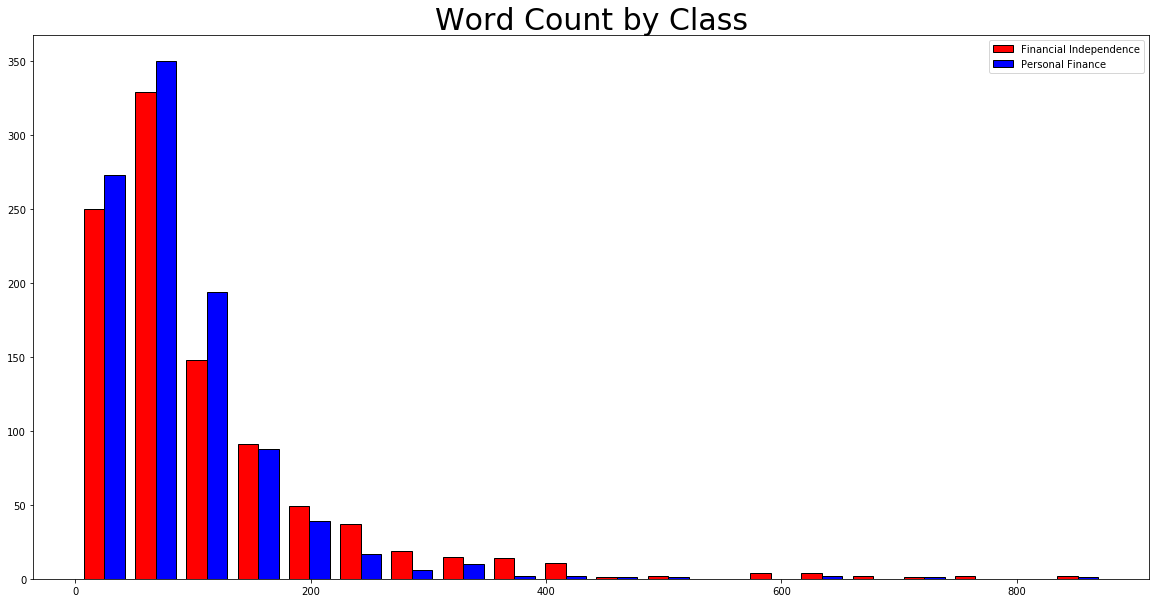

In [25]:
plt.figure(figsize=(20,10))
plt.hist([fewer_words[fewer_words['subreddit']=='financialindependence']['word_count'],
          fewer_words[fewer_words['subreddit']=='personalfinance']['word_count']],
         bins=20, color=['red', 'blue'], ec='k')
plt.title('Word Count by Class', fontsize=30)
plt.legend(['Financial Independence', 'Personal Finance'])

### `Count Vectorizer`
Going to examine the features for both subreddits

In [26]:
cvec = CountVectorizer()
training_count_features = cvec.fit_transform(X_train)
testing_count_features = cvec.transform(X_test)

> Create a dataframe to analyze terms from `CountVectorizer`

In [27]:
term_df = pd.DataFrame(training_count_features.toarray(), columns  = cvec.get_feature_names())
term_df['subreddit_class'] = y_train.values

term_df.head()

,aa,aaa,aautomoderator,ab,aback,abandon,abandoned,abandoning,abbreviation,abdominal,...,zjt,zm,zmw,zone,zqdh,zswwuthtsesbca,zvtsjgdn,zw,zx,subreddit_class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
term_df.shape

(1481, 9641)

In [29]:
term_df[['subreddit_class']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 1 columns):
subreddit_class    1481 non-null int64
dtypes: int64(1)
memory usage: 11.6 KB


In [30]:
term_df['subreddit_class'].value_counts()

1    746
0    735
Name: subreddit_class, dtype: int64

#### Most Frequent Words

In [31]:
print('===== Personal Finance (1.0) =====')
print(term_df.groupby('subreddit_class').mean().T.sort_values(by = 1.0, ascending = False).head(10), '\n')
print('===== Financial Independence (0.0) =====')
print(term_df.groupby('subreddit_class').mean().T.sort_values(by = 0.0, ascending = False).head(10))

===== Personal Finance (1.0) =====
subreddit_class         0         1
year             1.881633  1.178284
credit           0.057143  1.083110
would            0.896599  0.882038
month            0.536054  0.729223
account          0.387755  0.723861
pay              0.413605  0.683646
loan             0.201361  0.679625
card             0.054422  0.675603
money            0.719728  0.648794
get              0.665306  0.640751 

===== Financial Independence (0.0) =====
subreddit_class         0         1
year             1.881633  1.178284
would            0.896599  0.882038
work             0.816327  0.302949
like             0.801361  0.513405
time             0.780952  0.474531
money            0.719728  0.648794
fire             0.703401  0.006702
job              0.688435  0.481233
income           0.674830  0.333780
get              0.665306  0.640751


#### Least Frequent Words

In [32]:
print('===== Personal Finance (1.0) =====')
print(term_df.groupby('subreddit_class').mean().T.sort_values(by = 1.0, ascending = True).head(10), '\n')
print('===== Financial Independence (0.0) =====')
print(term_df.groupby('subreddit_class').mean().T.sort_values(by = 0.0, ascending = True).head(10))

===== Personal Finance (1.0) =====
subreddit_class         0    1
lcol             0.046259  0.0
lit              0.001361  0.0
lisbon           0.002721  0.0
linux            0.001361  0.0
linkedin         0.005442  0.0
lining           0.001361  0.0
linear           0.002721  0.0
limitless        0.002721  0.0
limitation       0.001361  0.0
limb             0.002721  0.0 

===== Financial Independence (0.0) =====
subreddit_class    0         1
comply           0.0  0.001340
preschool        0.0  0.001340
credible         0.0  0.001340
credited         0.0  0.004021
creditkarma      0.0  0.005362
stray            0.0  0.001340
creditwise       0.0  0.001340
implicate        0.0  0.001340
implemented      0.0  0.001340
creeper          0.0  0.001340


Going to look at the words with the greatest difference in frequency between the two classes

In [33]:
term_frequencies = term_df.groupby('subreddit_class').mean().T
term_frequencies['difference'] = abs(term_frequencies[1.0] - term_frequencies[0.0])
term_frequencies.sort_values('difference', ascending = False).head(20)

subreddit_class,0,1,difference
credit,0.057143,1.083110,1.025967
year,1.881633,1.178284,0.703348
fire,0.703401,0.006702,0.696699
card,0.054422,0.675603,0.621181
fi,0.521088,0.001340,0.519748
work,0.816327,0.302949,0.513377
loan,0.201361,0.679625,0.478264
post,0.542857,0.084450,0.458407
retirement,0.534694,0.184987,0.349707
income,0.674830,0.333780,0.341050


In [34]:
term_frequencies = term_df.groupby('subreddit_class').sum().T
term_frequencies['difference'] = abs(term_frequencies[1.0] - term_frequencies[0.0])
term_frequencies.sort_values('difference', ascending = False).head(20)

subreddit_class,0,1,difference
credit,42,808,766
fire,517,5,512
year,1383,879,504
card,40,504,464
fi,383,1,382
work,600,226,374
loan,148,507,359
post,399,63,336
account,285,540,255
retirement,393,138,255


In [35]:
multi_nb = MultinomialNB()
print('Training Score: ', cross_val_score(multi_nb, training_count_features, y_train).mean())

multi_nb.fit(training_count_features, y_train)
print('Testing Score: ', multi_nb.score(testing_count_features, y_test))

Training Score:  0.8811580754038317
Testing Score:  0.8927125506072875


**Evaluating the predictions**

In [36]:
y_pred = multi_nb.predict(testing_count_features)

In [37]:
confusion_matrix(y_test, y_pred)

array([[236,  17],
       [ 36, 205]])

- True Positive: Predicted & Actual == `personalfinance`
- True Negative: Predicted & Actual == `financialindependence`
- False Positive: Predicted == `personalfinance`, Actual == `financialindependence`
- False Negative: Predicted == `financialindependence`, Actual == `personalfinance`

## Predicting subreddit using Random Forests + Another Classifier

#### `MultinomialNB`

In [38]:
cvec = CountVectorizer()
model = MultinomialNB()

pipe = Pipeline([
    ('cvec', cvec),
    ('model', model)
])

params = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__binary': [True, False],
    'cvec__max_df': [0.8, 0.9, 1.0]
}

gs = GridSearchCV(pipe, param_grid = params)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor...zer=None, vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'cvec__max_features': [3000, 4000, 5000], 'cvec__ngram_range': [(1, 1), (1, 2)], 'cvec__binary': [True, False], 'cvec__max_df': [0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
print('CV Accuracy Score: ', gs.best_score_)
print('Test Accuracy Score: ', gs.score(X_test, y_test))
print(gs.best_params_)

CV Accuracy Score:  0.8919648885887913
Test Accuracy Score:  0.8967611336032388
{'cvec__binary': True, 'cvec__max_df': 0.8, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1)}


> Wonder what using the `TfidfVectorizer` would do...

In [40]:
tfidf = TfidfVectorizer()
model = MultinomialNB()

pipe = Pipeline([
    ('tfidf', tfidf),
    ('model', model)
])

params = {
    'tfidf__max_features': [2000, 3000, 4000],
    'tfidf__ngram_range': [(1,1), (1,2)],
}

gs = GridSearchCV(pipe, param_grid = params)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...e,
        vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tfidf__max_features': [2000, 3000, 4000], 'tfidf__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
print('CV Accuracy Score: ', gs.best_score_)
print('Test Accuracy Score: ', gs.score(X_test, y_test))
print(gs.best_params_)

CV Accuracy Score:  0.8825118163403106
Test Accuracy Score:  0.8765182186234818
{'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}


#### Create a `RandomForestClassifier` model to predict which subreddit a given post belongs to.

In [42]:
cvec = CountVectorizer()
model = RandomForestClassifier()

pipe = Pipeline([
    ('cvec', cvec),
    ('model', model)
])

params = {
    'cvec__binary': [True, False],
    'cvec__ngram_range': [(1,1), (1,2)],
    'model__max_depth': [250, 500],
    'model__n_estimators': [1000]
}

gs = GridSearchCV(pipe, param_grid = params)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'cvec__binary': [True, False], 'cvec__ngram_range': [(1, 1), (1, 2)], 'model__max_depth': [250, 500], 'model__n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
print('CV Accuracy Score: ', gs.best_score_)
print('Test Accuracy Score: ', gs.score(X_test, y_test))
print(gs.best_params_)

CV Accuracy Score:  0.9081701553004726
Test Accuracy Score:  0.9089068825910931
{'cvec__binary': False, 'cvec__ngram_range': (1, 1), 'model__max_depth': 500, 'model__n_estimators': 1000}


In [44]:
gs.best_estimator_.steps[1][1].feature_importances_

array([1.63741119e-05, 4.38626969e-06, 3.71694099e-05, ...,
       4.94010187e-06, 8.60679658e-06, 4.82326213e-08])

In [45]:
y_pred = gs.best_estimator_.predict(X_test)

In [46]:
confusion_matrix(y_test, y_pred)

array([[232,  21],
       [ 24, 217]])

**Confusion Matrix Results**  
232 True Negative (Predicted & Actual == Financial Independence)  
21 False Positive (Predicted Personal Finance, Actual Financial Independence)  
21 False Negative (Predicted Financial Independence, Actual Personal Finance)  
220 True Positive (Predicted & Actual == Personal Finance)

In [54]:
cvec = CountVectorizer()
model = LogisticRegression()

pipe = Pipeline([
    ('cvec', cvec),
    ('model', model)
])

params = {
    'cvec__binary': [True, False],
    'cvec__max_df': [3000, 4000, 5000],
    'model__penalty': ['l1', 'l2']
}

gs = GridSearchCV(pipe, param_grid = params)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'cvec__binary': [True, False], 'cvec__max_df': [3000, 4000, 5000], 'model__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
print('CV Accuracy Score: ', gs.best_score_)
print('Test Accuracy Score: ', gs.score(X_test, y_test))
print(gs.best_params_)

CV Accuracy Score:  0.8825118163403106
Test Accuracy Score:  0.8987854251012146
{'cvec__binary': True, 'cvec__max_df': 3000, 'model__penalty': 'l2'}


# Executive Summary
---
Put your executive summary in a Markdown cell below.

What characteristics of a post on Reddit contribute most to what subreddit it belongs to? Though seemingly trivial by itself, the answer to this question may provide insight on how to answer others that are similar in nature and ten-fold the importance. We may no longer have confusion over "who said what", as we will simply be able to look at "what" to accurately predict the "who".

By looking at the content of hundreds of posts related to subreddits r/financialindependence and r/personalfinance, we were able to identify vocab words and patterns that provide a distinction between the two. By and large, posts in both subreddits follows a very similar pattern; a concise title that describes the content to follow, and then a post describing the issue or advice being provided. However, the content of these titles and descriptions is far different.

We took nearly 2000 posts - 988 from financial independence, 987 from personal finance - and broke them down into the individual words. We removed common words like "the", "and", "for", etc. and then identified the words most commonly associated with each subreddit. We also looked at the words that appear most often in one subreddit versus the other; to signify their importance. After grabbing these individual "tokens", we created various models that could predict up to 91% accurately which subreddit they came from. We believe with more funding and experimentation, we can improve model accuracy, and also use this in other more useful applications.